In [1]:
import argparse
import json
import os
import warnings
import numpy as np
from utils import utils

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers.tensorboard import TensorBoardLogger

import utils.args_parser  as argtools
import utils.tools as utools
from utils.constants import Cte
from models import deepsvdd, adcar, adar

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
parser = argparse.ArgumentParser(description=__doc__)
parser.add_argument('--dataset_file', default='_params/dataset_loan_all.yaml', type=str,
                    help='path to configuration file for the dataset')
parser.add_argument('--model_file', default='_params/model_vaca_loan.yaml', type=str,
                    help='path to configuration file for the dataset')
parser.add_argument('--trainer_file', default='_params/trainer.yaml', type=str,
                    help='path to configuration file for the training')
parser.add_argument('--yaml_file', default='', type=str, help='path to trained model configuration')
parser.add_argument('-d', '--dataset_dict', action=argtools.StoreDictKeyPair, metavar="KEY1=VAL1,KEY2=VAL2...",
                    help='manually define dataset configurations as string: KEY1=VALUE1+KEY2=VALUE2+...')
parser.add_argument('-m', '--model_dict', action=argtools.StoreDictKeyPair, metavar="KEY1=VAL1,KEY2=VAL2...",
                    help='manually define model configurations as string: KEY1=VALUE1+KEY2=VALUE2+...')
parser.add_argument('-o', '--optim_dict', action=argtools.StoreDictKeyPair, metavar="KEY1=VAL1,KEY2=VAL2...",
                    help='manually define optimizer configurations as string: KEY1=VALUE1+KEY2=VALUE2+...')
parser.add_argument('-t', '--trainer_dict', action=argtools.StoreDictKeyPair, metavar="KEY1=VAL1,KEY2=VAL2...",
                    help='manually define trainer configurations as string: KEY1=VALUE1+KEY2=VALUE2+...')
parser.add_argument('-s', '--seed', default=0, type=int, help='set random seed, default: random')
parser.add_argument('-r', '--root_dir', default='', type=str, help='directory for storing results')
parser.add_argument('--data_dir', default='', type=str, help='data directory')

parser.add_argument('-i', '--is_training', default=0, type=int,
                    help='run with training (1) or without training (0)')
# parser.add_argument('-f', '--eval_fair', default=True, action="store_true",
#                     help='run code with counterfactual fairness experiment (only for German dataset), default: False')
parser.add_argument('--show_results', default=0, action="store_true",
                    help='run with evaluation (1) or without(0), default: 1')

parser.add_argument('--plots', default=0, type=int, help='run code with plotting (1) or without (0), default: 0')

# DeepSVDD
parser.add_argument('--training_size', default=10000, type=int, help='training size')
parser.add_argument('--train_deepsvdd', default=0, type=int, help='train (1) or load(0) deepsvdd')

parser.add_argument('--max_epoch_deepsvdd', default=1000, type=int, help='max epoch for training deepsvdd')
parser.add_argument('--batch_size_deepsvdd', default=1024, type=int, help='batch size for training deepsvdd')
parser.add_argument('--out_dim_deepsvdd', default=2048, type=int, help='output dim for deepsvdd')
parser.add_argument('--nu_deepsvdd', default=0.005, type=float, help='quantile for deepsvdd')

# ADCAR
parser.add_argument('--train_ADCAR', default=0, type=int, help='train (1) or load(0) ADCAR')
parser.add_argument('--train_ADAR', default=0, type=int, help='train (1) or load(0) ADAR')
parser.add_argument('--cost_function', default=1, type=int, help='using cost function')
parser.add_argument('--l2_alpha', default=1e-3, type=float, help='Weight for the l2 loss')
parser.add_argument('--device', default='cuda:1', type=str, help='Device to use')
parser.add_argument('--max_epoch_ADCAR', default=100, type=int, help='max epoch for training ADCAR')
parser.add_argument('--batch_size_ADCAR', default=128, type=int, help='batch size for training ADCAR')
parser.add_argument('--learning_rate_ADCAR', default=1e-4, type=float, help='Learning rate for ADCAR')

parser.add_argument('--r_ratio', default=0.0, type=float, help='R ratio for flap samples')


args = parser.parse_args('')

# %%
if args.yaml_file == '':
    cfg = argtools.parse_args(args.dataset_file)
    cfg.update(argtools.parse_args(args.model_file))
    cfg.update(argtools.parse_args(args.trainer_file))
else:
    cfg = argtools.parse_args(args.yaml_file)
if len(args.root_dir) > 0:  cfg['root_dir'] = args.root_dir
if int(args.seed) >= 0:
    cfg['seed'] = int(args.seed)


# %%
pl.seed_everything(cfg['seed'])
utils.set_seed(cfg['seed'])

if args.dataset_dict is not None: cfg['dataset']['params2'].update(args.dataset_dict)
if args.model_dict is not None: cfg['model']['params'].update(args.model_dict)
if args.optim_dict is not None: cfg['optimizer']['params'].update(args.optim_dict)
if args.trainer_dict is not None: cfg['trainer'].update(args.trainer_dict)

if isinstance(cfg['trainer']['gpus'], int):
    cfg['trainer']['auto_select_gpus'] = False
    cfg['trainer']['gpus'] = -1

cfg['dataset']['params'] = cfg['dataset']['params1'].copy()
cfg['dataset']['params'].update(cfg['dataset']['params2'])

if len(args.data_dir) > 0:
    cfg['dataset']['params']['data_dir'] = args.data_dir

print(args.dataset_dict)
print(cfg['dataset']['params'])
print(cfg['model']['params'])

# %% Load dataset

data_module = None

if cfg['dataset']['name'] in Cte.DATASET_LIST:
    from data_modules.het_scm import HeterogeneousSCMDataModule

    dataset_params = cfg['dataset']['params'].copy()
    dataset_params['dataset_name'] = cfg['dataset']['name']
    dataset_params['num_samples_tr'] = args.training_size

    data_module = HeterogeneousSCMDataModule(**dataset_params)

    data_module.prepare_data()

assert data_module is not None, cfg['dataset']

# %% Load model
model_vaca = None
model_params = cfg['model']['params'].copy()
# VACA
if cfg['model']['name'] == Cte.VACA:
    from models.vaca.vaca import VACA

    model_params['is_heterogeneous'] = data_module.is_heterogeneous
    model_params['likelihood_x'] = data_module.likelihood_list

    model_params['deg'] = data_module.get_deg(indegree=True)
    model_params['num_nodes'] = data_module.num_nodes
    model_params['edge_dim'] = data_module.edge_dimension
    model_params['scaler'] = data_module.scaler

    model_vaca = VACA(**model_params)
    model_vaca.set_random_train_sampler(data_module.get_random_train_sampler())
# VACA with PIWAE
elif cfg['model']['name'] == Cte.VACA_PIWAE:
    from models.vaca.vaca_piwae import VACA_PIWAE

    model_params['is_heterogeneous'] = data_module.is_heterogeneous

    model_params['likelihood_x'] = data_module.likelihood_list

    model_params['deg'] = data_module.get_deg(indegree=True)
    model_params['num_nodes'] = data_module.num_nodes
    model_params['edge_dim'] = data_module.edge_dimension
    model_params['scaler'] = data_module.scaler

    model_vaca = VACA_PIWAE(**model_params)
    model_vaca.set_random_train_sampler(data_module.get_random_train_sampler())



# MultiCVAE
elif cfg['model']['name'] == Cte.MCVAE:
    from models.multicvae.multicvae import MCVAE

    model_params['likelihood_x'] = data_module.likelihood_list

    model_params['topological_node_dims'] = data_module.train_dataset.get_node_columns_in_X()
    model_params['topological_parents'] = data_module.topological_parents
    model_params['scaler'] = data_module.scaler
    model_params['num_epochs_per_nodes'] = int(
        np.floor((cfg['trainer']['max_epochs'] / len(data_module.topological_nodes))))
    model_vaca = MCVAE(**model_params)
    model_vaca.set_random_train_sampler(data_module.get_random_train_sampler())
    cfg['early_stopping'] = False

# CAREFL
elif cfg['model']['name'] == Cte.CARELF:
    from models.carefl.carefl import CAREFL

    model_params['node_per_dimension_list'] = data_module.train_dataset.node_per_dimension_list
    model_params['scaler'] = data_module.scaler
    model_vaca = CAREFL(**model_params)
assert model_vaca is not None

utools.enablePrint()

print(model_vaca.model)
model_vaca.summarize()
model_vaca.set_optim_params(optim_params=cfg['optimizer'],
                            sched_params=cfg['scheduler'])

# %% Evaluator

evaluator = None

if cfg['dataset']['name'] in Cte.DATASET_LIST:
    from models._evaluator import MyEvaluator

    evaluator = MyEvaluator(model=model_vaca,
                            intervention_list=data_module.train_dataset.get_intervention_list(),
                            scaler=data_module.scaler
                            )

assert evaluator is not None

model_vaca.set_my_evaluator(evaluator=evaluator)

# %% Prepare training
if args.yaml_file == '':
    if (cfg['dataset']['name'] in [Cte.GERMAN]) and (cfg['dataset']['params3']['train_kfold'] == True):
        save_dir = argtools.mkdir(os.path.join(cfg['root_dir'],
                                               argtools.get_experiment_folder(cfg),
                                               str(cfg['seed']), str(cfg['dataset']['params3']['kfold_idx'])))
    else:
        save_dir = argtools.mkdir(os.path.join(cfg['root_dir'],
                                               argtools.get_experiment_folder(cfg),
                                               str(cfg['seed'])))
else:
    save_dir = os.path.join(*args.yaml_file.split('/')[:-1])
print(f'Save dir: {save_dir}')
# trainer = pl.Trainer(**cfg['model'])
logger = TensorBoardLogger(save_dir=save_dir, name='logs', default_hp_metric=False)
out = logger.log_hyperparams(argtools.flatten_cfg(cfg))

save_dir_ckpt = argtools.mkdir(os.path.join(save_dir, 'ckpt'))
ckpt_file = argtools.newest(save_dir_ckpt)
callbacks = []
if args.is_training == 1:

    checkpoint = ModelCheckpoint(period=1,
                                 monitor=model_vaca.monitor(),
                                 mode=model_vaca.monitor_mode(),
                                 save_top_k=1,
                                 save_last=True,
                                 filename='checkpoint-{epoch:02d}',
                                 dirpath=save_dir_ckpt)

    callbacks = [checkpoint]

    if cfg['early_stopping']:
        early_stopping = EarlyStopping(model_vaca.monitor(), mode=model_vaca.monitor_mode(), min_delta=0.0,
                                       patience=50)
        callbacks.append(early_stopping)

    if ckpt_file is not None:
        print(f'Loading model training: {ckpt_file}')
        trainer = pl.Trainer(logger=logger, callbacks=callbacks, resume_from_checkpoint=ckpt_file,
                             **cfg['trainer'])
    else:

        trainer = pl.Trainer(logger=logger, callbacks=callbacks, **cfg['trainer'])

    # %% Train

    trainer.fit(model_vaca, data_module)
    # save_yaml(model.get_arguments(), file_path=os.path.join(save_dir, 'hparams_model.yaml'))
    argtools.save_yaml(cfg, file_path=os.path.join(save_dir, 'hparams_full.yaml'))
    # %% Testing

else:
    # %% Testing
    trainer = pl.Trainer()
    print('\nLoading from: ')
    print(ckpt_file)

    model_vaca = model_vaca.load_from_checkpoint(ckpt_file, **model_params)
    evaluator.set_model(model_vaca)
    model_vaca.set_my_evaluator(evaluator=evaluator)

    if cfg['model']['name'] in [Cte.VACA_PIWAE, Cte.VACA, Cte.MCVAE]:
        model_vaca.set_random_train_sampler(data_module.get_random_train_sampler())

model_parameters = filter(lambda p: p.requires_grad, model_vaca.parameters())
params = int(sum([np.prod(p.size()) for p in model_parameters]))

print(f'Model parameters: {params}')
model_vaca.eval()
model_vaca.freeze()  # IMPORTANT

if args.show_results:
    output_valid = model_vaca.evaluate(dataloader=data_module.val_dataloader(),
                                       name='valid',
                                       save_dir=save_dir,
                                       plots=False)
    output_test = model_vaca.evaluate(dataloader=data_module.test_dataloader(),
                                      name='test',
                                      save_dir=save_dir,
                                      plots=args.plots)
    output_valid.update(output_test)

    output_valid.update(argtools.flatten_cfg(cfg))
    output_valid.update({'ckpt_file': ckpt_file,
                         'num_parameters': params})

    with open(os.path.join(save_dir, 'output.json'), 'w') as f:
        json.dump(output_valid, f)
    print(f'Experiment folder: {save_dir}')

dataset_params['num_samples_tr'] = args.training_size * 10
data_module = HeterogeneousSCMDataModule(**dataset_params)
data_module.prepare_data()
thres_n, thres_ab, df_train, df_valid, df_test = utils.split_dataset(data_module, name=cfg['dataset']['name'], \
                                                                     training_size=args.training_size,
                                                                     seed=args.seed)


if cfg['dataset']['name'] == 'loan':
    input_dim = data_module.train_dataset.X0.shape[-1]
elif cfg['dataset']['name'] == 'adult':
    input_dim = data_module.train_dataset.X0.shape[-1] - 4
elif cfg['dataset']['name'] == 'donors':
    input_dim = data_module.train_dataset.X0.shape[-1] - 1
else:
    NotImplementedError

model_deepsvdd = deepsvdd.DeepSVDD(input_dim=input_dim, out_dim=args.out_dim_deepsvdd,
                                   batch_size=args.batch_size_deepsvdd, nu=args.nu_deepsvdd,
                                   max_epoch=args.max_epoch_deepsvdd, data=data_module.dataset_name,
                                   device=args.device)

if cfg['dataset']['name'] == 'loan':
    train_X = data_module.scaler.transform(data_module.train_dataset.X0)
    valid_X = data_module.scaler.transform(data_module.valid_dataset.X0)
    test_X = data_module.scaler.transform(data_module.test_dataset.X0)
elif cfg['dataset']['name'] == 'adult':
    train_X = data_module.scaler.transform(data_module.train_dataset.X0)[:, :-4]
    valid_X = data_module.scaler.transform(data_module.valid_dataset.X0)[:, :-4]
    test_X = data_module.scaler.transform(data_module.test_dataset.X0)[:, :-4]
elif cfg['dataset']['name'] == 'donors':
    train_X = data_module.scaler.transform(data_module.train_dataset.X0)[:, :-1]
    valid_X = data_module.scaler.transform(data_module.valid_dataset.X0)[:, :-1]
    test_X = data_module.scaler.transform(data_module.test_dataset.X0)[:, :-1]
else:
    NotImplementedError

if args.train_deepsvdd:
    print('Training DeepSVDD:')
    model_deepsvdd.train_DeepSVDD(train_X, valid_X)

print('Results for DeepSVDD:')
model_deepsvdd.load_model()
model_deepsvdd.get_R(train_X)
if cfg['dataset']['name'] == 'donors':
    lst_dist, lst_pred = model_deepsvdd.predict(test_X, label=df_test['is_exciting'].values, result=1)
else:
    lst_dist, lst_pred = model_deepsvdd.predict(test_X, label=df_test['label'].values, result=1)

if cfg['dataset']['name'] == 'loan':
    out_dim = 6
elif cfg['dataset']['name'] == 'adult':
    out_dim = 3
elif cfg['dataset']['name'] == 'donors':
    out_dim = 3
else:
    NotImplementedError


model_adar = adar.ADAR(input_dim, out_dim, model_deepsvdd, model_vaca, data_module,
                       alpha=1e-3, batch_size=args.batch_size_ADCAR, max_epoch=args.max_epoch_ADCAR,
                       device=args.device, data=cfg['dataset']['name'], cost_f=args.cost_function,
                       R_ratio=args.r_ratio, lr=args.learning_rate_ADCAR)
                       # device=args.device, data=cfg['dataset']['name'], cost_f=args.cost_function, R_ratio=i)
x_train, u_train, x_valid, u_valid, x_test, u_test, df = utils.prepare_adcar_training_data(df_test, lst_pred, data_module,
                                                                                           cfg['dataset']['name'])
if args.train_ADAR:
    print('Training ADAR:')
    model_adar.train_ADAR(x_train, u_train, x_valid, u_valid)
print('Results for ADAR:')
# model_adar.predict(x_train, u_train)
model_adar.predict(x_test, u_test, thres_n=thres_n)

print('-'*50)
model_adcar = adcar.ADCAR(input_dim, out_dim, model_deepsvdd, model_vaca, data_module,
                       alpha=args.l2_alpha, batch_size=args.batch_size_ADCAR, max_epoch=args.max_epoch_ADCAR,
                       device=args.device, data=cfg['dataset']['name'], cost_f=args.cost_function, R_ratio=args.r_ratio)
                       # device=args.device, data=cfg['dataset']['name'], cost_f=args.cost_function, R_ratio=i)

if args.train_ADCAR:
    print('Training ADCAR:')
    model_adcar.train_ADCAR(x_train, u_train, x_valid, u_valid)
print('Results for ADCAR:')
# model_adcar.predict(x_train, u_train)
model_adcar.predict(x_test, u_test, thres_n=thres_n)

Global seed set to 0


None
{'data_dir': '../Data', 'batch_size': 1000, 'num_workers': 0, 'num_samples_tr': 100000, 'equations_type': 'linear', 'normalize': 'lik', 'likelihood_names': 'b_d_d_d_d_d_d', 'lambda_': 0.05, 'normalize_A': None}
{'architecture': 'dgnn', 'estimator': 'elbo', 'h_dim_list_dec': [16, 16, 16], 'h_dim_list_enc': [16, 16], 'z_dim': 4, 'distr_z': 'normal', 'dropout_adj_rate': 0.0, 'dropout_adj_pa_rate': 0.2, 'dropout_adj_pa_prob_keep_self': 0.0, 'residual': 0.0, 'norm_categorical': 0}



  | Name  | Type        | Params
--------------------------------------
0 | model | HVACAModule | 33.9 K
--------------------------------------
33.9 K    Trainable params
0         Non-trainable params
33.9 K    Total params
0.136     Total estimated model params size (MB)
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


HVACAModule(
  (_encoder_embeddings): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (4): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (5): Sequential(
      (0): Linear(in_features=1, out_features=16, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.0, inplace=False)
    )
    (6): Sequential(
      (0): Linear(in_features=1, out_features=1

VACA results:
DeepSVDD pred: 1.0
GT CR: 0.9829545454545454
Delta x Avg Real: 13.223175048828125
Ab GT Avg Real: 12.926557540893555
Delta x Avg Org: 15.991211126625082
Ab GT Avg Org: 15.782893873584879

GT results:
DeepSVDD pred w causal: 1.0
GT CR w causal: 0.9829545454545454
GT x Avg w causal: 19.153582223853775
Ab GT Avg w causal: 19.037807491842766

Case study
index = 2

In [3]:
index = 0

In [4]:
x_theta_adar, _,_, df_adar = model_adar.get_result(x_test[index], u_test[index])
x_theta_adcar, _,_, df_adcar = model_adcar.get_result(x_test[index], u_test[index])
index += 1
df_adar

,G,A,E,L,D,I,S,y
0,0.0,1.777420,-0.285987,2.634188,8.309877,0.433239,-17.877808,0.000020
1,0.0,4.786379,-1.800556,-6.663777,-1.959621,0.725189,-5.849524,0.444509
2,0.0,4.786377,-0.439481,-6.560385,-10.853296,1.026085,-4.960255,0.925322


In [5]:
x_theta_adar

array([  3.0089588 ,  -1.5145698 ,  -9.297966  , -10.269498  ,
         0.29195014,  12.028285  ], dtype=float32)

In [6]:
df_adcar

,G,A,E,L,D,I,S,y
0,0.0,1.777420,-0.285987,2.634188,8.309877,0.433239,-17.877808,0.000020
1,0.0,3.085906,-0.804421,-3.571100,1.477729,-3.051472,-14.604983,0.999834
2,0.0,3.443241,-0.423402,-4.002234,0.588625,-2.374586,-17.264688,0.999408


In [7]:
x_theta_adcar

array([ 1.6658206, -1.2295107, -6.716037 , -1.2514127, -2.9744072,
        1.2629786], dtype=float32)

In [8]:
index

1

In [15]:
import torch
x_org = []
x_pred = []
x_gt = []
for i in range(len(x_test)):
    _, _, _, df = model_adcar.get_result(x_test[i], u_test[i])
    if df.iloc[1,-1] > 0.9 and df.iloc[2,-1] > 0.9:
        x_org.append(df.iloc[0, :-1].values)
        x_pred.append(df.iloc[1, :-1].values)
        x_gt.append(df.iloc[2, :-1].values)
x_org = data_module.scaler.transform(x_org).to(args.device)
x_pred = data_module.scaler.transform(x_pred).to(args.device)
x_gt = data_module.scaler.transform(x_gt).to(args.device)
x_org_res = model_deepsvdd.net.forward(x_org.float()).data.cpu().numpy()
x_pred_res = model_deepsvdd.net.forward(x_pred.float()).data.cpu().numpy()
x_norm_res = model_deepsvdd.net.forward(train_X[:len(x_org_res)].to(args.device)).data.cpu().numpy()
x_gt_res = model_deepsvdd.net.forward(x_gt.float()).data.cpu().numpy()
center = model_deepsvdd.c.numpy()
print(len(x_org))

In [16]:
state = 0

state = 109, perplexity=100, n_iter=2000,  n_iter_without_progress=100, learning_rate=200 \
perplexity=60, random_state=109, n_iter=5000, n_iter_without_progress=300, learning_rate=10 4groups

In [17]:
from sklearn import manifold
import matplotlib.pyplot as plt
import matplotlib
all = x_pred_res + [center]


tsne = manifold.TSNE(n_components=2, init='random', perplexity=100, random_state=109, n_iter=2000, 
                     n_iter_without_progress=100, learning_rate=200)
# tsne = manifold.MDS(n_components=2, random_state=state)
# tsne = manifold.Isomap(n_components=2)
# tsne = manifold.LocallyLinearEmbedding(n_components=2, eigen_solver='dense', random_state=state)
# tsne = manifold.SpectralEmbedding(n_components=2, affinity='rbf')

tsne_all = tsne.fit_transform(all)
tsne_org = tsne.fit_transform(x_org_res)
# tsne_norm = tsne.fit_transform(x_norm_res)
# tsne_normal_t = tsne.fit_transform(X_normal_t)
# tsne_abnormal_t = tsne.fit_transform(X_abnormal_t)

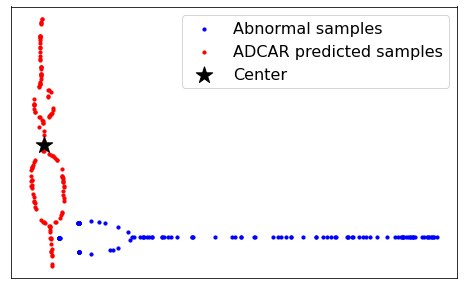

In [18]:
plt.figure(figsize=(8,5))
matplotlib.rcParams.update({'font.size': 16})
plt.scatter(tsne_org[:,0],tsne_org[:,1], color = 'b', marker='o', s=10, alpha = 1.0,label = 'Abnormal samples')
# plt.scatter(tsne_norm[:,0],tsne_norm[:,1], marker='o', s=10, alpha = 1.0,label = 'Normal samples')
plt.scatter(tsne_all[:-1,0],tsne_all[:-1,1], color = 'r', marker='o', s=10, alpha = 1.0 ,label = 'ADCAR predicted samples')
plt.scatter(tsne_all[-1,0],tsne_all[-1,1], color = 'black',marker='*', s=300, alpha = 1.0,label = 'Center')

plt.legend(loc='best')
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# plt.show()
plt.savefig('Loan_tsne_2.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [19]:
all = x_pred_res + [center]


tsne = manifold.TSNE(n_components=2, init='random', perplexity=60, random_state=109, n_iter=5000, 
                     n_iter_without_progress=300, learning_rate=100)
# tsne = manifold.MDS(n_components=2, random_state=state)
# tsne = manifold.Isomap(n_components=2)
# tsne = manifold.LocallyLinearEmbedding(n_components=2, eigen_solver='dense', random_state=state)
# tsne = manifold.SpectralEmbedding(n_components=2, affinity='rbf')

tsne_all = tsne.fit_transform(all)
tsne_org = tsne.fit_transform(x_org_res)
tsne_norm = tsne.fit_transform(x_norm_res)
tsne_gt = tsne.fit_transform(x_gt_res)
# tsne_normal_t = tsne.fit_transform(X_normal_t)
# tsne_abnormal_t = tsne.fit_transform(X_abnormal_t)

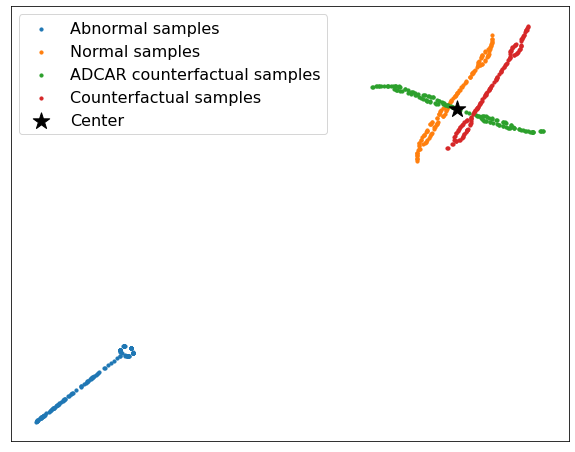

In [20]:
plt.figure(figsize=(10,8))
matplotlib.rcParams.update({'font.size': 16})
plt.scatter(tsne_org[:,0],tsne_org[:,1], marker='o', s=10, alpha = 1.0,label = 'Abnormal samples')
plt.scatter(tsne_norm[:,0],tsne_norm[:,1], marker='o', s=10, alpha = 1.0,label = 'Normal samples')
plt.scatter(tsne_all[:-1,0],tsne_all[:-1,1], marker='o', s=10, alpha = 1.0 ,label = 'ADCAR counterfactual samples')
plt.scatter(tsne_gt[:,0],tsne_gt[:,1],  marker='o', s=10, alpha = 1.0 ,label = 'Counterfactual samples')
plt.scatter(tsne_all[-1,0],tsne_all[-1,1], color = 'black',marker='*', s=300, alpha = 1.0,label = 'Center')

plt.legend(loc='best')
ax = plt.gca()
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
# plt.show()
plt.savefig('Loan_tsne_3.png', dpi=300, bbox_inches='tight', pad_inches=0.1)